# Heuristics for finding clusters

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
from collections import Counter

## MST implementation

In [2]:
def total_distance(clusters, dist_matrix):
    total_distance = 0
    for cluster in clusters:
        cluster_points = list(cluster)
        for i in range(len(cluster_points)):
            for j in range(i + 1, len(cluster_points)):
                total_distance += dist_matrix[cluster_points[i], cluster_points[j]]
    return total_distance

def mst_clustering(data, k, algorithm='prim'):
    # Compute the distance matrix
    dist_matrix = squareform(pdist(data, metric='euclidean'))

    # Convert the distance matrix into a weighted graph
    G = nx.Graph()
    for i in range(len(dist_matrix)):
        for j in range(i + 1, len(dist_matrix)):  # Avoid duplicates
            G.add_edge(i, j, weight=dist_matrix[i, j])

    # Compute the MST using the specified algorithm
    if algorithm not in ['prim', 'kruskal']:
        raise ValueError("Invalid algorithm specified. Use 'prim' or 'kruskal'.")
    mst = nx.minimum_spanning_tree(G, algorithm=algorithm)

    # Remove the k-1 largest edges
    edges = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    for _ in range(k - 1):
        edge_to_remove = edges.pop(0)
        mst.remove_edge(edge_to_remove[0], edge_to_remove[1])

    # Extract connected components as clusters
    clusters = list(nx.connected_components(mst))
    cluster_assignments = np.zeros(len(data), dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for point in cluster:
            cluster_assignments[point] = cluster_id

    # Calculate within-cluster distances
    total_dist = total_distance(clusters, dist_matrix)

    return {
        "assignments": cluster_assignments,
        "total_distance": total_dist
    }

def plot_clusters(data, cluster_assignments, title="MST Clustering"):
    plt.figure(figsize=(8, 6))
    for cluster_id in np.unique(cluster_assignments):
        cluster_points = data[cluster_assignments == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_clusters_3d(data, cluster_assignments, title="MST Clustering in 3D"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster_id in np.unique(cluster_assignments):
        cluster_points = data[cluster_assignments == cluster_id]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                   label=f"Cluster {cluster_id}", s=50, alpha=0.8)

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    plt.show()

## Wine dataset

Explained variance by each principal component: [0.36198848 0.1920749  0.11123631]
Total Within-Cluster Distance: 72876.83140692214


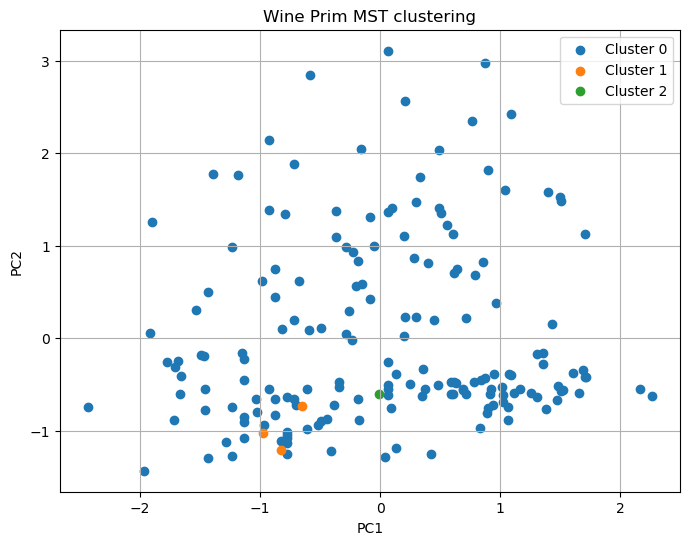

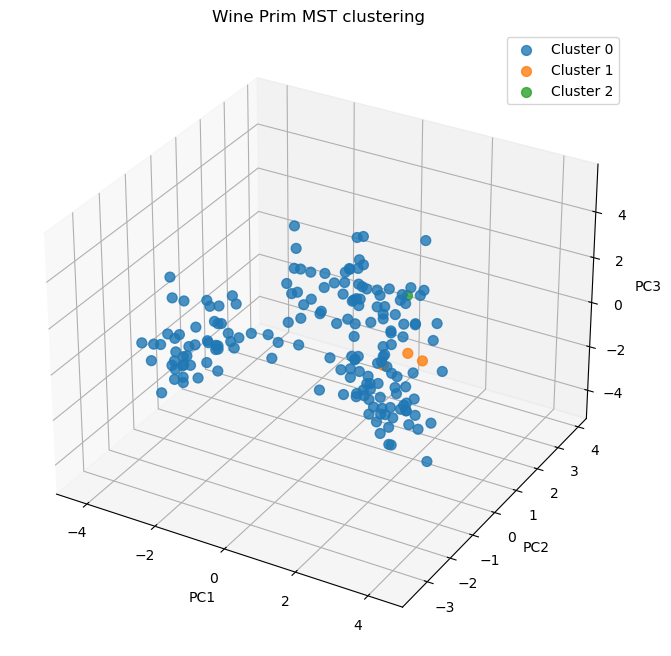

In [3]:
DATA_PATH = Path('data/wine-clustering.csv')
NAMES = [
    'Alcohol',
    'Malic_Acid',
    'Ash','Ash_Alcanity',
    'Magnesium',
    'Total_Phenols',
    'Flavanoids',
    'Nonflavanoid_Phenols',
    'Proanthocyanins',
    'Color_Intensity',
    'Hue',
    'OD280',
    'Proline'
]
N_CLUSTERS = 3
df = pd.read_csv(DATA_PATH)

data = df[NAMES].to_numpy()
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

result_prim = mst_clustering(data, N_CLUSTERS, 'prim')
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

print("Explained variance by each principal component:", pca.explained_variance_ratio_)
print("Total Within-Cluster Distance:", result_prim["total_distance"])

# Visualize clusters
plot_clusters(data, result_prim["assignments"], 'Wine Prim MST clustering')
plot_clusters_3d(data_pca, result_prim["assignments"], 'Wine Prim MST clustering')

In [4]:
class_counts = Counter(result_prim["assignments"])
print(class_counts)

Counter({0: 174, 1: 3, 2: 1})


Explained variance by each principal component: [0.36198848 0.1920749  0.11123631]
Total Within-Cluster Distance: 72876.83140692214


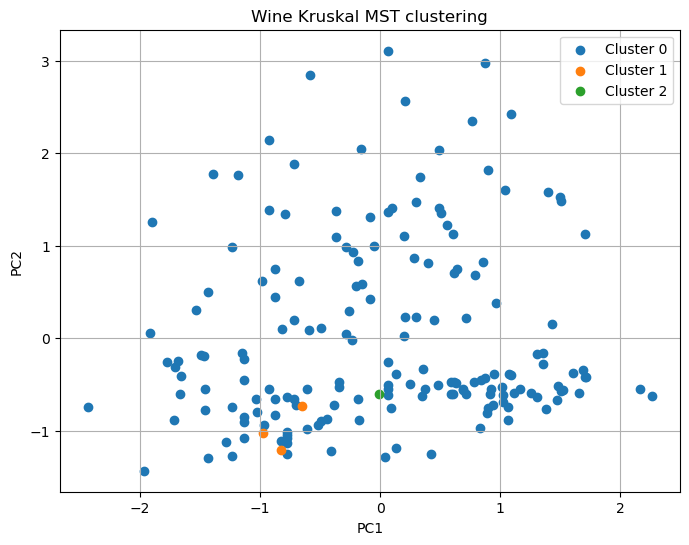

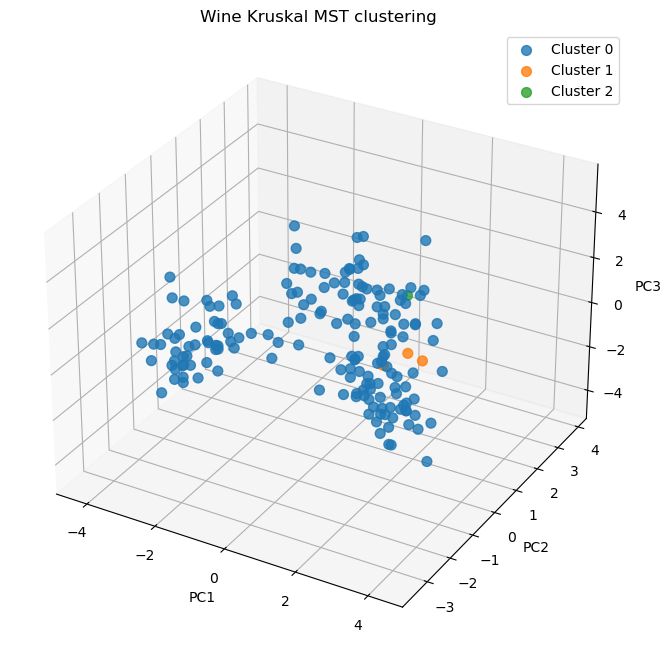

In [5]:
result_kruskal = mst_clustering(data, N_CLUSTERS, 'kruskal')
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

print("Explained variance by each principal component:", pca.explained_variance_ratio_)
print("Total Within-Cluster Distance:", result_kruskal["total_distance"])

# Visualize clusters
plot_clusters(data, result_kruskal["assignments"], 'Wine Kruskal MST clustering')
plot_clusters_3d(data_pca, result_kruskal["assignments"], 'Wine Kruskal MST clustering')

In [6]:
class_counts = Counter(result_kruskal["assignments"])
print(class_counts)

Counter({0: 174, 1: 3, 2: 1})


## Iris dataset

Explained variance by each principal component: [0.72770452 0.23030523 0.03683832]
Total Within-Cluster Distance: 9636.68428743288


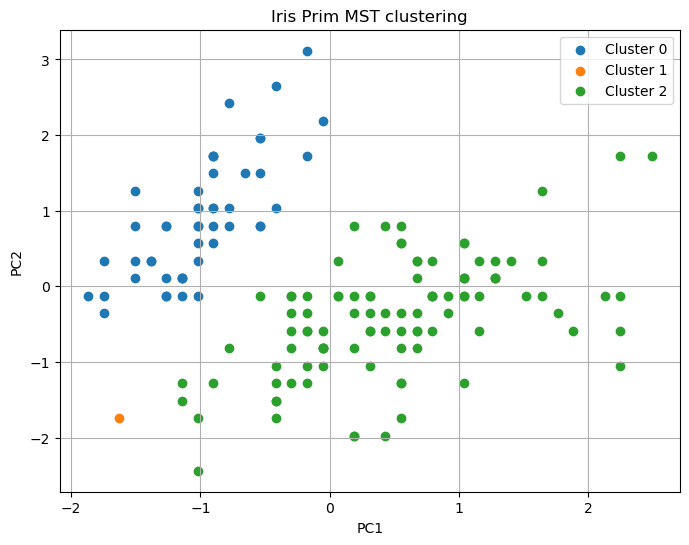

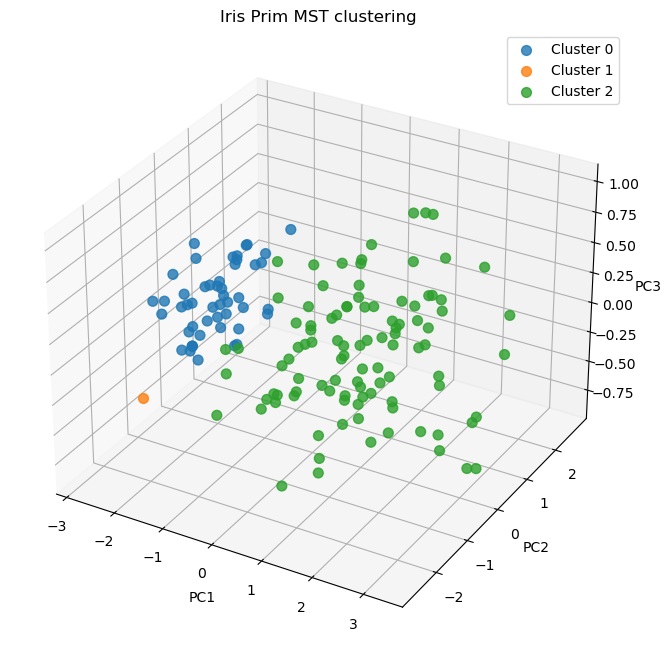

In [13]:
DATA_PATH = Path('data/iris.csv')
N_CLUSTERS = 3

df = pd.read_csv(DATA_PATH, header=None, skiprows=1)

data = df.to_numpy()
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

result_prim = mst_clustering(data, N_CLUSTERS, 'prim')
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

print("Explained variance by each principal component:", pca.explained_variance_ratio_)
print("Total Within-Cluster Distance:", result_prim["total_distance"])

# Visualize clusters
plot_clusters(data, result_prim["assignments"], 'Iris Prim MST clustering')
plot_clusters_3d(data_pca, result_prim["assignments"], 'Iris Prim MST clustering')

In [14]:
class_counts = Counter(result_prim["assignments"])
print(class_counts)

Counter({2: 100, 0: 49, 1: 1})


Explained variance by each principal component: [0.72770452 0.23030523 0.03683832]
Total Within-Cluster Distance: 9636.68428743288


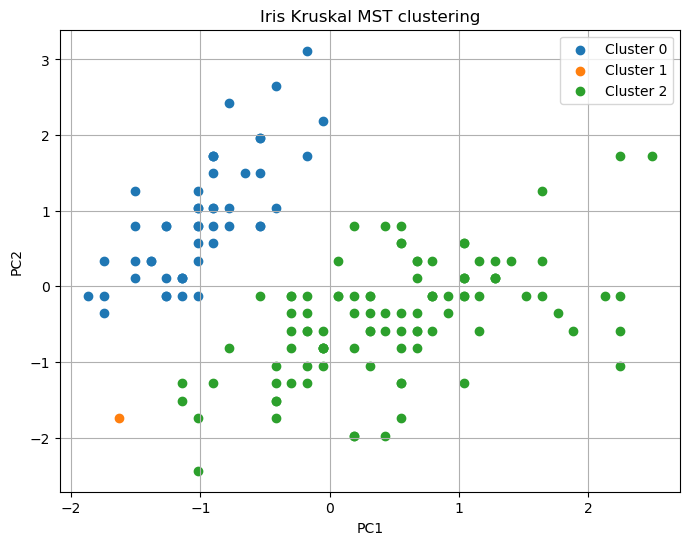

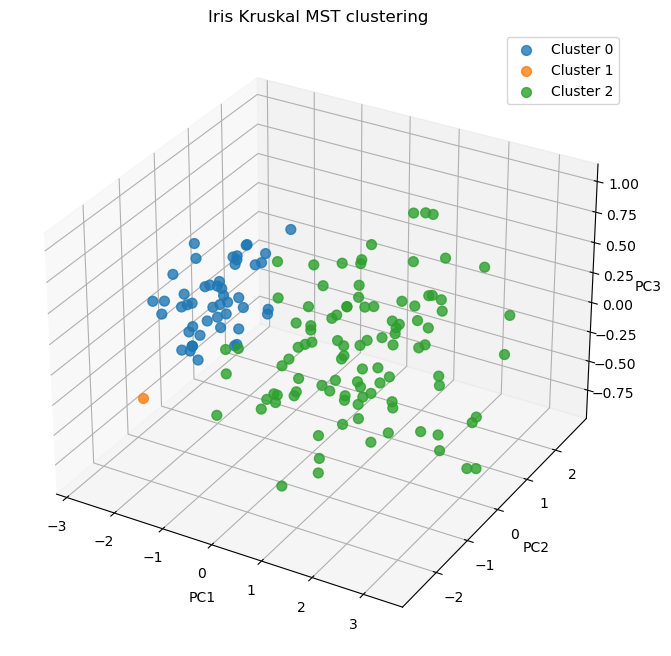

In [15]:
result_kruskal = mst_clustering(data, N_CLUSTERS, 'kruskal')
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

print("Explained variance by each principal component:", pca.explained_variance_ratio_)
print("Total Within-Cluster Distance:", result_kruskal["total_distance"])

# Visualize clusters
plot_clusters(data, result_kruskal["assignments"], 'Iris Kruskal MST clustering')
plot_clusters_3d(data_pca, result_prim["assignments"], 'Iris Kruskal MST clustering')

In [16]:
class_counts = Counter(result_kruskal["assignments"])
print(class_counts)

Counter({2: 100, 0: 49, 1: 1})
